# Customized Services


This example will show how to intergrate the following external functions as customized services in **Agentscope**:
- langchain tools 
- dashscope text-to-image
- dashscope image-to-text
- dashscope text-to-audio

Meanwhile, we are consistently working on bringing more and more services into **Agentscope**. The external services introduced in these examples will soon be merged into our library and have official support!

_Current progress_: Langchain tools 🚧, dashscope_text_to_image 🚧, dashscope_image_to_text 🚧, dashscope_text_to_audio 🚧...


## Tested Models

These models are tested in this example. For other models, some modifications may be needed.
- gpt-4
- gpt-3.5-turbo

## Prerequisites
- Follow [READMD.md](https://github.com/modelscope/agentscope) to install AgentScope. 
- Run folling code to install other required library includes [LangChain](https://python.langchain.com/v0.1/docs/get_started/quickstart/) and [Dashscope](https://dashscope.aliyun.com/).```!pip install langchain dashscope pyowm```
- Prepare a model configuration. AgentScope supports both local deployed model services (CPU or GPU) and third-party services. More details and example model configurations please refer to our [tutorial](https://modelscope.github.io/agentscope/en/tutorial/203-model.html).
- Prepare API keys for `OpenWeatherMao` and `Dashscope` 

## Table of Contents 
- [Background](##Background)
- [Langchain Tools](##Langchain-tools)
- [Dashscope](#dashscope)
    - [Text2Img](###Text-to-Image)
    - [Img2Text](###Image-to-Text)
    - [Text2Audio](###Text-to-Audio)



---

## Background

In **Agentscope**, a "service" is a set of multi-functional utility tools that can be used to enhance the capabilities of agents. **Agentscope** has provided a variety of services, including executing Python code, web searching, file operations, and so on. For more details, we refer the reader to agentscope/tutorials/services. we refere the reader to [agentscope/tutorials/services](https://modelscope.github.io/agentscope/en/tutorial/204-service.html.


For tools that are not covered in **Agentscope**, implementing a customized service is as simple as writing a custom function, as shown below:
```python
from agentscope.service.service_response import ServiceResponse, ServiceExecStatus
def your_customized_services(argument_1, argument_2) -> ServiceResponse
```

Note that the returned type of your function should be of class `ServiceResponse`.

`ServiceResponse` is a wrapper for the execution results of the services, containing two fields: `status` and `content`. When the Service function runs to completion normally, `status` is `ServiceExecStatus.SUCCESS`, and `content` is the return value of the function. When an error occurs during execution, `status` is `ServiceExecStatus.Error`, and content contains the error message.

`AgentScope` introduces `ServiceToolkit` that handles the interaction between LLM agents and services for you. Most importantly, you should provide a Well-formatted docstring (Google style is recommended) for you function, and `ServiceToolkit` will automatically parse the docstring and generate usage instruction for LLM agents. An example could be:

```python
"""
This function is used to...

Args: 
    argument_1: (`str`): 
        the description of argument_1
    argument_2: (`int`)
        the description of argument_2

Returns:
    ServiceResponse: A dictionary with two variables: `status` and
        `content`. If `status` is ServiceExecStatus.SUCCESS, the `content` is {the description of the expected returned value}.

Example: 
    An example of the usage of and the returned value of your function.
"""
```

Then, you can register your function using 
```python

from agentscope.service import ServiceToolkit
service_toolkit = ServiceToolKit()
service_toolkit.add(your_customize_services, argument_1, argument_2)
```

---

## Langchain tools
The package of Langchain also offers a variety of tools that may not be covered in  **AgentScope**. You may find a full list of tools supported in Langchain here [Supported Toolkits in Langchain](https://python.langchain.com/v0.1/docs/integrations/tools/)

Let's take the tool `OpenWeatherMap` as an example. `Langchain` provides wrappers for all tool in `.utilities.Wrapper` 

In [3]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper
import os
os.environ['OPENWEATHERMAP_API_KEY'] = "OPENWEATHERMAP_API_KEY"
weather = OpenWeatherMapAPIWrapper()
weather_data = weather.run("London,GB")
print(weather_data)

In London,GB, the current weather is as follows:
Detailed status: fog
Wind speed: 1.54 m/s, direction: 320°
Humidity: 93%
Temperature: 
  - Current: 11.52°C
  - High: 12.36°C
  - Low: 9.49°C
  - Feels like: 11.16°C
Rain: {}
Heat index: None
Cloud cover: 100%


We can wrap the call of `Wrapper` into a function to make it available as an `Agentscope` service. 

In [4]:
from agentscope.service.service_response import ServiceResponse
from agentscope.service.service_status import ServiceExecStatus

def get_weather_data(city: str, 
                     country: str, 
                     api_key: str) -> ServiceResponse:
    """Search the weather data of a city

    Args:
        city (`str`): the name of the city.
        country (`str`): the name of the country.
        api_key (str): The api key for the openweathermap api.
    Returns:
        ServiceResponse:  
        A dictionary with two variables: `status` and`content`. 
        If `status` is ServiceExecStatus.SUCCESS, 
        the `content` contains the weather data of the queried city.
    Example: 
        city = "London"
        country = "GB"
        print(get_weather_data(city, country, api_key)) gives:
        In London,GB, the current weather is as follows:
        Detailed status: scattered clouds
        Wind speed: 3.6 m/s, direction: 210°
        Humidity: 85%
        Temperature: 
            - Current: 12.34°C
            - High: 13.08°C
            - Low: 11.39°C
            - Feels like: 11.85°C
        Rain: {}
        Heat index: None
        Cloud cover: 40%
            
    """
    os.environ['OPENWEATHERMAP_API_KEY'] = api_key
    weather = OpenWeatherMapAPIWrapper()
    try:
        weather_data = weather.run(f"{city},{country}")
        return ServiceResponse(ServiceExecStatus.SUCCESS, weather_data)
    except Exception as e:
        return ServiceResponse(ServiceExecStatus.FAILURE, str(e))

Now, let's add it to the `ServiceToolKit`. 

In [5]:
from agentscope.service import service_toolkit
toolkit  = service_toolkit.ServiceToolkit()
toolkit.add(get_weather_data, api_key="OPENWEATHERMAP_API_KEY")

In [7]:
YOUR_MODEL_CONFIGURATION_NAME = "gpt-4"
YOUR_MODEL_CONFIGURATION = {
    "config_name": "gpt-4",
    "model_type": "openai_chat",
    "model_name": "gpt-4",
    "api_key": "YOUR OPENAI API KEY"
}
import agentscope
from agentscope.agents import ReActAgent
agentscope.init(model_configs=YOUR_MODEL_CONFIGURATION)
agent = ReActAgent(
    name="assistant",
    model_config_name="gpt-4",
    service_toolkit=toolkit, 
    verbose=True # set verbose to True to show  reasoning process
)
from agentscope.message import Msg
msg_question = Msg(
    name="user", 
    content="Which city is better to visit today, London or Paris?", 
    role="user"
)
res = agent(msg_question)

>>> Executing function get_weather_data with arguments:
>>> 	country: United Kingdom
>>> 	city: London
>>> END 
>>> Executing function get_weather_data with arguments:
>>> 	country: France
>>> 	city: Paris
>>> END 


In [11]:
print(res.content)

Both London and Paris have cloudy weather today. However, Paris is slightly warmer than London with a temperature of 12.58°C compared to London's 11.6°C. Therefore, you might find Paris more comfortable to visit today.


Looks Good.

---

## Dashscope

Through flexible and user-friendly model API services, **Dashscope** enables the capabilities of various large AI models to be easily accessible to AI developers. [Click here for a full list of supported models and tasks (in zh-cn)](https://dashscope.console.aliyun.com/model?spm=5176.28630291.0.0.24bf7eb5lzPBes).

The procedure of wraping **Dashscope** as services in **Agentscope** is the same. We need to define a function with clear documentation to call the api. In this section, we implement three services: text-to-image, image-to-text, text-to-audio.

In [12]:
from http import HTTPStatus
import dashscope
import requests

### Text to Image

In [13]:
def text_to_image(prompt:str, 
                  api_key:str,
                  number_of_images:int=1,
                  size:str='1024*1024',
                  model:str='wanx-v1') -> ServiceResponse:
    """Generate an image based on a text prompt.

    Args:
        prompt (`str`): the text prompt.
        api_key (`str`): The api key for the dashscope api.
        number_of_images (`int`, defaults to `1`): the number of images to generate. 
        size (`str`, defaults to `1024*1024`): the size of the image.
        model (`str`, defaults to 'wanx-v1'): the model to use.
    Returns:
        ServiceResponse:  
        A dictionary with two variables: `status` and`content`. 
        If `status` is ServiceExecStatus.SUCCESS, 
        the `content` is a dict with key urls and a list of the urls of the generated images.

    Example:
        prompt = "A beautiful sunset in the mountains"
        print(text_to_image(prompt)) gives:
        {'status': 'SUCCESS', 'content': {'urls': ['URL1', 'URL2']}}
    """
    dashscope.api_key = api_key
    response  = dashscope.ImageSynthesis.call(
        model=model,
        prompt=prompt,
        n=number_of_images,
        size=size)
    if response.status_code == HTTPStatus.OK:
        urls = []
        for i, result in enumerate(response.output.results):
            file_name = f"generated_image_{i}.png"
            urls.append(file_name)
            with open('./%s' % file_name, 'wb+') as f:
                f.write(requests.get(result.url).content)
        return ServiceResponse(ServiceExecStatus.SUCCESS, {"urls": urls})
    else:
        err_msg = f"status_code: {response.status_code}, code: {response.code}, message: {response.message}"
        return ServiceResponse(ServiceExecStatus.FAILURE, err_msg)

### Image to text

In [14]:
def image_to_text(image_url:str,
                  query_prompt:str, 
                  api_key:str,
                  model:str="qwen-vl-plus") -> ServiceResponse:
    """Generate text based on an image.
    
    Args:
        image_url (`str`): the url of the image.
        query_prompt (`str`): the text prompt.
        api_key (`str`): The api key for the dashscope api.
        model (`str`, defaults to 'qwen-vl-plus'): the model to use.
    Returns:
        ServiceResponse:  
        A dictionary with two variables: `status` and`content`. 
        If `status` is ServiceExecStatus.SUCCESS, 
        the `content` is the generated text.
    Example:
        image_url = "image.jpg"
        query_prompt = "Describe the image"
        print(image_to_text(image_url, query_prompt)) gives:
        {'status': 'SUCCESS', 'content': 'A beautiful sunset in the mountains'}
    """
    dashscope.api_key = api_key
    # get absolute path of the image
    image_path = os.path.abspath(image_url)
    image_url = f"file://{image_path}"
    message = [
        {"role":"user", 
         "content":[
             {"image": image_url},
             {"text": query_prompt}
         ]},
    ]
    response = dashscope.MultiModalConversation.call(model=model, 
                                                     messages=message)
    if response.status_code == HTTPStatus.OK:
        description = response.output.choices[0].message.content[0]['text']
        return ServiceResponse(ServiceExecStatus.SUCCESS, description)
    else:
        err_msg = f"status_code: {response.status_code}, code: {response.code}, message: {response.message}"
        return ServiceResponse(ServiceExecStatus.FAILURE, err_msg)    
                  

### Text to audio

In [15]:
def text_to_audio(text:str, 
                  api_key:str,
                  model:str='sambert-zhichu-v1',
                  sample_rate:int=48000) -> ServiceResponse:
    """Convert text to audio.
    
    Args:
        text (`str`): the text to convert.
        api_key (`str`): The api key for the dashscope api.
        model (`str`, defaults to 'sambert-zhichu-v1'): the model to use.
        sample_rate (`int`, defaults to 48000): the sample rate of the audio.
    Returns:
        ServiceResponse:  
        A dictionary with two variables: `status` and`content`. 
        If `status` is ServiceExecStatus.SUCCESS, 
        the `content` is the URL of the generated audio file.
    Example:
        text = "How is the weather today?"
        print(text_to_audio(text)) gives:
        {'status': 'SUCCESS', 'content': 'AUDIO_URL'}
    """
    from dashscope.audio.tts import SpeechSynthesizer
    import nest_asyncio
    nest_asyncio.apply()
    dashscope.api_key = api_key
    result = SpeechSynthesizer.call(model=model,
                                                text=text,
                                                sample_rate=sample_rate)
    if result.get_audio_data() is not None:
        with open('output.wav', 'wb') as f:
            f.write(result.get_audio_data())
        return ServiceResponse(ServiceExecStatus.SUCCESS, 'output.wav')
    else:
        return ServiceResponse(ServiceExecStatus.FAILURE, "Failed to generate audio file")

In [18]:
toolkit = service_toolkit.ServiceToolkit()
YOUR_API_KEY = "YOUR DASHSCOPE API KEY"
toolkit.add(text_to_image, api_key=YOUR_API_KEY, model="wanx-v1", size="1024*1024")
toolkit.add(image_to_text, api_key=YOUR_API_KEY, model="qwen-vl-plus")
toolkit.add(text_to_audio, api_key=YOUR_API_KEY, model="sambert-zhichu-v1", sample_rate=48000)
agentscope.init(model_configs=YOUR_MODEL_CONFIGURATION)
agent = ReActAgent(
    name="assistant",
    model_config_name=YOUR_MODEL_CONFIGURATION_NAME,
    service_toolkit=toolkit, 
    verbose=True, # set verbose to True to show  reasoning process
)
msg_question = Msg(
    name="user", 
    content=("What's the creature inside the image: image.png" 
             "draw me a picture of the environment of this creature's habitat"
             "and describe the environment in audio"), 
    role="user",
    verbose=True
)
res = agent(msg_question)

>>> Executing function image_to_text with arguments:
>>> 	image_url: image.png
>>> 	query_prompt: What is the creature in the image?
>>> END 
>>> Executing function text_to_image with arguments:
>>> 	number_of_images: 1
>>> 	prompt: A typical habitat of a rabbit including meadows, w...
>>> END 
>>> Executing function text_to_audio with arguments:
>>> 	text: The habitat depicts various environments where you...
>>> END 


In [19]:
print(res.content)

I have generated a description of the rabbit's habitat and converted it to audio format for you. You should now understand where rabbits usually live.


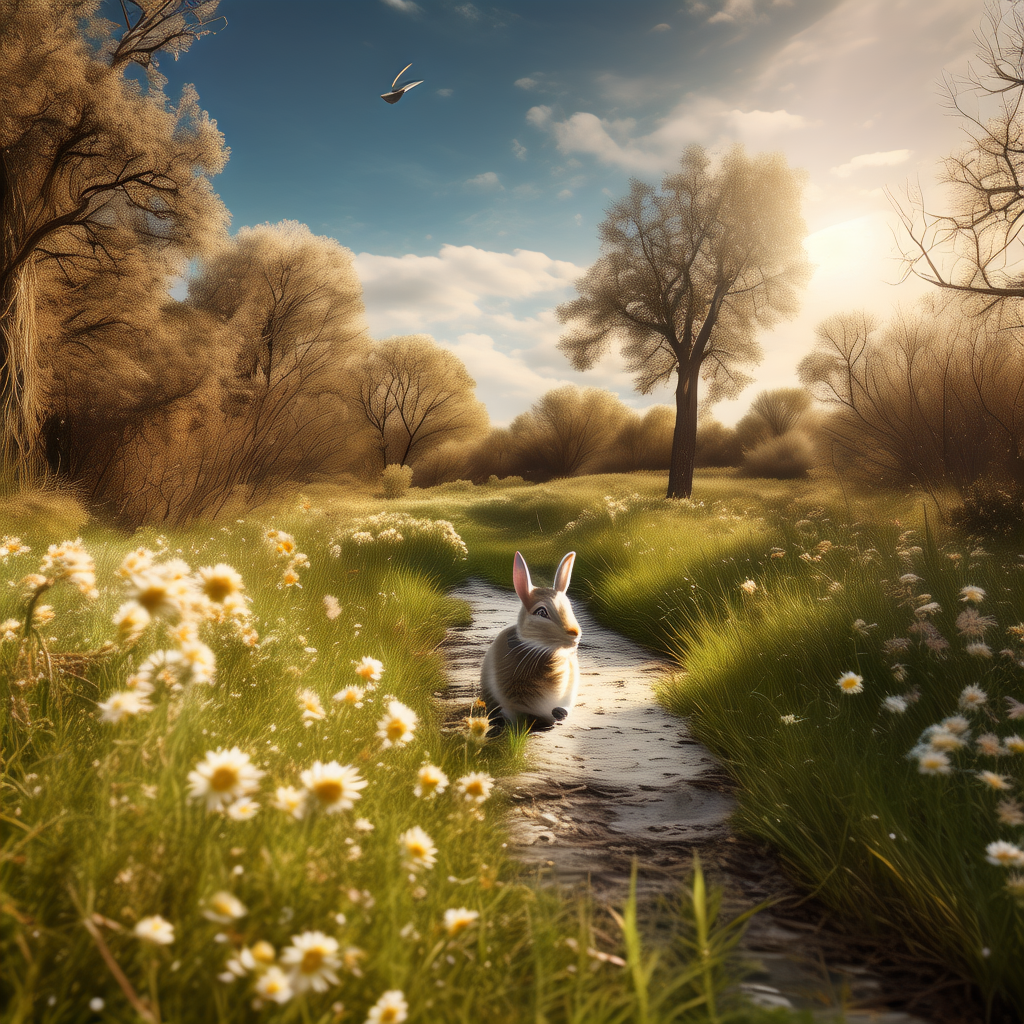

In [20]:
import IPython
# display the generated image
IPython.display.Image("generated_image_0.png")

In [21]:
IPython.display.Audio("output.wav")